# Data Modelling II - Classification

In this unit, we will look at building models which involve *classifying* data; each set of data points fit into one of a number of categories (e.g.: kind of fruit, win/loss, home country, etc.), and once the model has been trained, it will predict what category new sets of data will fit into.  The three main modelling techniques we will be reviewing are logistic regression, decision trees, and naive Bayes classification.  

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy import stats, special
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 10.0)

Populating the interactive namespace from numpy and matplotlib


## Logistic Regression

We learned linear and polynomial regression in the previous unit, to model a simple mathematical function to a set of numerical data.  What happens when our data isn't numerical, though, but *categorical*? e.g.: the provinces that a list of people live in, what schools a certain group attended, the top 5 most populous plant species per year, etc.

We'll look at the simple case where the *dependent* variable is categorical, and has only one of two values (for ease, we can refer to them as $0$ and $1$).  The way we can use regression to model such data is via the **sigmoid function**:
$$ \sigma(x) = \frac{1}{1+e^{-x}} $$

(-7, 7)

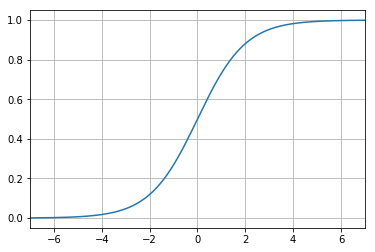

In [3]:
x = np.arange(-7,7,0.01)
plt.plot(x,special.expit(x));
plt.grid()
plt.xlim(-7,7)

As $x\to -\infty$, the function asymptotically approaches $0$, and as $x\to+\infty$, the function asymptotically approaches $1$.  This will help us split our categorical results into $0$ and $1$; we accomplish this by trying to find the parameters $\beta_0,\beta_1$ such that our dependent variable $y$ has the form:

$$ y = \begin{cases} 1,\,\text{ if }\,\beta_0+\beta_1x + \epsilon > 0 \\ 0,\,\text{  otherwise  }\end{cases} $$

We feed this equation of the line into the logistic function; by transforming the function, we can essentially create a boundary along $x$ whereby for some given $c$, if $x<c$ then the result is 0, and if $x>c$ the result is 1 (or vice versa).  The logistic function takes on the form:

$$ \sigma(x) = \frac{1}{1+ e^{-(\beta_0 + \beta_1x + \epsilon)}} $$


As a somewhat extreme example, the transformation to 

$$  \sigma(x) = \frac{1}{1+e^{20x-12}} $$ 
looks like:

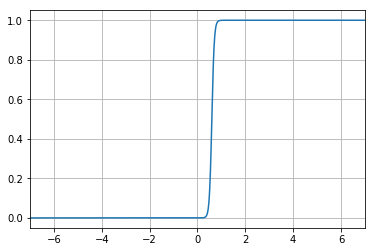

In [4]:
plt.plot(x,special.expit(20*x -12))
plt.grid()
plt.xlim(-7,7);

Let's look at an example.  Suppose 25 candidates with similar work experience interview for similar jobs at the same large company, in different offices, and spent between 0 and 3 hours researching the company before the interview.  A question we may ask is "how is the probability that the candidate will be hired affected by how long they spent researching the company"?

In [5]:
cr = pd.DataFrame({'Hours Researched':[0, 0, 0.5, 0.75, 1.0, 1.0, 1.25, 1.25, 1.5, 1.5, 1.75, 1.75, 
                                       1.9, 2.0, 2.0, 2.0, 2.0, 2.25, 2.25, 2.25, 2.5, 2.5, 2.75, 3.0, 3.0],
                   'Hired':[0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1]})

cr.head(10)

,Hours Researched,Hired
0,0.00,0
1,0.00,0
2,0.50,0
3,0.75,0
4,1.00,0
5,1.00,0
6,1.25,1
7,1.25,0
8,1.50,0
9,1.50,0


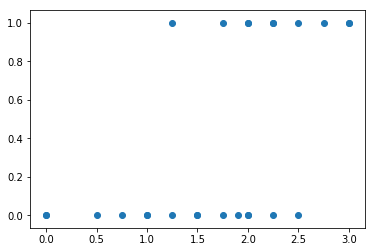

In [6]:
scatter(cr['Hours Researched'],cr['Hired']);

We can use scikit-learn's `linear_model.LogisticRegression()` (with a dizzying set of possible arguments) to create a logistic regression model for our data.  We set a variable name to an instance of the logistic regression, and then call `variablename.fit(x,y)` for our data.

It expects a particular format for the independent data set, and will throw up errors if you try to simply pass it `cr['Hours Researched']`.  We need to reshape the data in the following way:

In [7]:
cr['Hours Researched'].values.reshape(-1,1)

array([[0.  ],
       [0.  ],
       [0.5 ],
       [0.75],
       [1.  ],
       [1.  ],
       [1.25],
       [1.25],
       [1.5 ],
       [1.5 ],
       [1.75],
       [1.75],
       [1.9 ],
       [2.  ],
       [2.  ],
       [2.  ],
       [2.  ],
       [2.25],
       [2.25],
       [2.25],
       [2.5 ],
       [2.5 ],
       [2.75],
       [3.  ],
       [3.  ]])

We call our instance `logreg`, and then feed it our data:

In [8]:
logreg = linear_model.LogisticRegression(solver='newton-cg')
#X = cr['Hours Researched'].reset_index().values
X = cr['Hours Researched'].values.reshape(-1,1)
Y = cr['Hired']
logreg.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

We can then pull the coefficient ($\beta_1$) and the intercept ($\beta_0$) using:

In [9]:
hours_researched_slope = logreg.coef_[0][0]
logreg.coef_[0][0]

1.3842071770473567

In [10]:
hours_researched_intercept = logreg.intercept_[0]
logreg.intercept_[0]

-2.910324077435781

This allows us to plot the logistic function with our parameters:
$$ \sigma(x) = \frac{1}{1+e^{-(1.3842071770473567x -2.910324077435781)}}$$

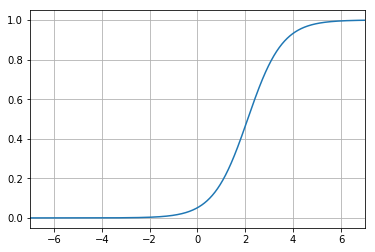

In [11]:
a = logreg.coef_[0][0]
b = logreg.intercept_[0]
plt.plot(x,special.expit(a*x+b))
plt.grid()
plt.xlim(-7,7);

We can use this function to predict the *probability* that a given amount of research time will result in being hired.

In [22]:
hours = [0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0]
ph = pd.DataFrame({'Hours Researched':hours,'Prob. of Hiring':[special.expit(a*x+b) for x in hours]})
ph

,Hours Researched,Prob. of Hiring
0,0.0,0.844302
1,0.5,0.821075
2,1.0,0.795222
3,1.5,0.766696
4,2.0,0.735517
5,2.5,0.701792
6,3.0,0.665722
7,3.5,0.627603
8,4.0,0.587829


In [29]:
logreg.predict_proba([[1.2]])

array([[0.21586709, 0.78413291]])

Scikit-learn also has an in-built `.predict()` function for our regression model which will output either `0` or `1` for a given argument:

In [30]:
logreg.predict([[1.67]])[0]

1

In [31]:
logreg.predict([[1]])[0]

1

In [32]:
logreg.predict([[3]])[0]

1

In [33]:
logreg.predict([[2.9]])[0]

1

Hence, the model predicts that researching for 1.67 hours will not result in being hired, but 2.9 hours of research will result in being hired.<br>  (As a note, we haven't done any model validation for this.  Obviously, there are many factors that lead to being hired for a job which we did not account for in this fairly simple model.  We need to keep these issues in mind when analyzing a data set, and deciding how to model what we have.)

Example 2:

Let's look at another example.  Suppose we had data from a number of users of a specific kind of smart phone that consisted of an amount of time the phone was in constant use from a full charge, and whether the battery had run out (0) or not (1) at the end of the time period.  (Note: what the phone was being used for is not specified in the data, and could potentially affect the model; e.g.: the battery will probably run out faster if you are running five apps simultaneously, while also on a call, as opposed to only using it to listen to music. These are things to keep in mind when creating models.)

In [34]:
phb = pd.DataFrame({'Time Period':[0.5, 0.75, 1.4, 2.0, 2.5, 4.0, 4.6, 5.75, 5,9, 7.1, 8.0, 8.2, 8.5, 9.0, 9.1,9.5,10],
                   'Battery':[1,1,1,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0]})
phb

,Time Period,Battery
0,0.50,1
1,0.75,1
2,1.40,1
3,2.00,0
4,2.50,1
5,4.00,0
6,4.60,1
7,5.75,1
8,5.00,0
9,9.00,1


In [35]:
logreg = linear_model.LogisticRegression(solver='newton-cg')
#X = cr['Hours Researched'].reset_index().values
X = phb['Time Period'].values.reshape(-1,1)
Y = phb['Battery']
logreg.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

-0.3338985630490562
1.6905938915896277


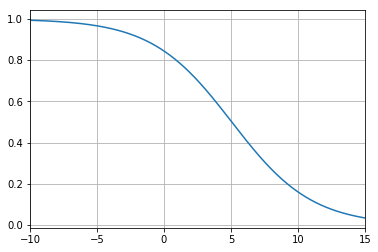

In [36]:
x = np.arange(-10,15,0.01)
a = logreg.coef_[0][0]
time_period_battery_slope = logreg.coef_[0][0]
print(a)
b = logreg.intercept_[0]
time_period_battery_intercept = logreg.intercept_[0]
print(b)
plt.plot(x,special.expit(a*x+b))
plt.grid()
plt.xlim(-10,15);

In [37]:
logreg.coef_[0][0]

-0.3338985630490562

In [38]:
hours = np.arange(0,12,0.1)
ph = pd.DataFrame({'Hours Used':hours,'Prob. of Battery':[special.expit(a*x+b) for x in hours]})
ph.head(10)

,Hours Used,Prob. of Battery
0,0.0,0.844302
1,0.1,0.839862
2,0.2,0.835320
3,0.3,0.830676
4,0.4,0.825927
5,0.5,0.821075
6,0.6,0.816117
7,0.7,0.811053
8,0.8,0.805883
9,0.9,0.800606


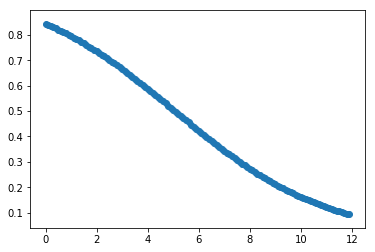

In [39]:
scatter(ph['Hours Used'],ph['Prob. of Battery']);

We can see that the cutoff at $50\%$ probability occurs right around the 5 hour mark:

In [40]:
ph[(ph['Prob. of Battery']<0.54) & (ph['Prob. of Battery'] > 0.46)]

,Hours Used,Prob. of Battery
46,4.6,0.538588
47,4.7,0.530281
48,4.8,0.521956
49,4.9,0.513619
50,5.0,0.505275
51,5.1,0.496928
52,5.2,0.488582
53,5.3,0.480243
54,5.4,0.471915
55,5.5,0.463602


Predicting the state of the battery at 5.0 hours and at 5.2 hours gives:

In [41]:
logreg.predict([[5.0]])[0]

1

In [42]:
logreg.predict([[5.2]])[0]

0

Question:  the slope of the sigmoid for this model does not increase/decrease as sharply as the model for the job-interviews model.  In fact, the battery model does not even start approaching 0 asymptotically for the window-size of the graph we made, which is 5 hours greater than the maximum data point we have.  What do we think this may mean for the accuracy of the two models? 

In [43]:
hours_researched_slope

1.3842071770473567

In [44]:
hours_researched_intercept

-2.910324077435781

In [45]:
time_period_battery_slope

-0.3338985630490562

In [46]:
time_period_battery_intercept

1.6905938915896277

### Logistic Regression with Multiple Features

The two examples we saw only had a single feature.  Logistic regression can be extended to multi-dimensional features in much the same way that linear regression can.  If we consider the values of the features as a vector $\textbf{x} = \begin{bmatrix} 1 & x_1 & x_2 & \cdots & x_n\end{bmatrix}^T$, then we're solving for a vector $\beta = \begin{bmatrix}\beta_0 & \beta_1 & \beta_2 & \cdots & \beta_n\end{bmatrix}^T$, mininizing the error in the training data (again, in the same way for linear regression).  Then our model is a function $\sigma:\,\mathbb{R}^n\to \mathbb{R}$ of the form:

$$ \sigma(\textbf{x}) = \frac{1}{1+ e^{-\beta^T\textbf{x}}}. $$

In fact, if we think carefully about the logistic regression we have done so far, it already has had this form:  $\textbf{x} = \begin{bmatrix} x & 1\end{bmatrix}^T$, and $\beta = \begin{bmatrix} \beta_1 & \beta_0\end{bmatrix}^T$, giving:

$$ \beta^T\textbf{x} = \beta_1x + \beta_0. $$

We'll look at data for loans applications, and try to model it with logistic regression.

In [47]:
loans = pd.read_csv('loans.csv',index_col=0)
loans.head(10)

,Credit Score,Loan Request Amount,Approval
0,548,56,0
1,625,168,0
2,899,237,1
3,608,84,0
4,783,34,1
5,735,213,0
6,472,213,0
7,661,150,0
8,645,46,1
9,821,247,1


This data contains loan applications for different customers, containing their credit score (ranging from 300 to 900, with a higher number being better), the loan request amount in \$100s, and the approval being 0 if the loan was denied and 1 if it was approved.

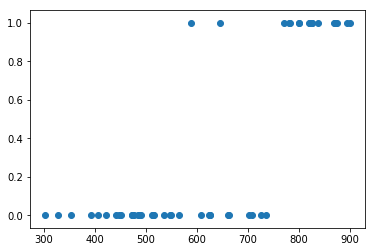

In [48]:
scatter(loans['Credit Score'],loans['Approval']);

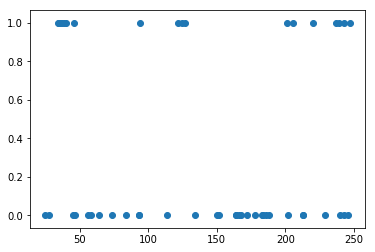

In [49]:
scatter(loans['Loan Request Amount'],loans['Approval']);

In [32]:
loans['Approval'].head(10)

index
0    0
1    0
2    1
3    0
4    1
5    0
6    0
7    0
8    1
9    1
Name: Approval, dtype: int64

In [33]:
loans.corr()

,Credit Score,Loan Request Amount,Approval
Credit Score,1.000000,-0.013193,0.796041
Loan Request Amount,-0.013193,1.000000,-0.084494
Approval,0.796041,-0.084494,1.000000


So there is definitely a strong linear relation between score and loan approval, but not nearly as strong a relation between loan amount and approval.  While we will continue with the exercise for illustrative purposes, these are things to keep in mind when selecting our model (the model validation tools we will be learning next unit will also help).  

One thing to note, though, is that there is *not* a strong linear relation between the *independent* variables.  This is a good sign, because high multicollinearity between features can lead to an increase in standard errors of the model.  In other words, if the features have high multicollinearity, it becomes difficult to ascertain the true impact of each of the features.

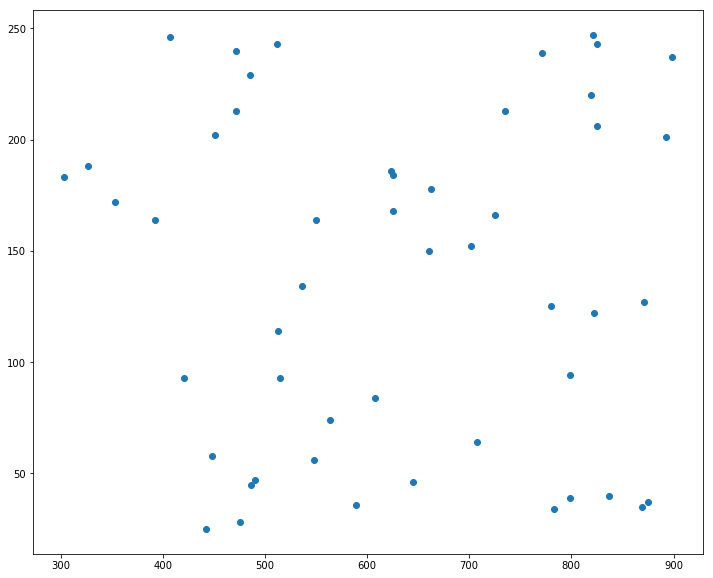

In [34]:
scatter(loans['Credit Score'],loans['Loan Request Amount']);

We feed the data to the `linear_model.LogisticRegression()` the same as above, but now our `X` consists of multiple columns.

In [35]:
lgrg = linear_model.LogisticRegression(solver='newton-cg')
X = loans[['Credit Score','Loan Request Amount']]
Y = loans['Approval']
lgrg.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

When we look at the coefficient, we get two values:

In [36]:
loans_credit_score_coeff = lgrg.coef_[0][0]
loans_credit_score_coeff

0.035266202335864957

In [37]:
loans_request_amount_coeff = lgrg.coef_[0][1]
loans_request_amount_coeff

-0.024040156305937171

In [38]:
loans_intercept = lgrg.intercept_[0]
loans_intercept

-21.585517815920081

These are the values of $\beta_1$ and $\beta_2$.  The intercept, $\beta_0$ is still obtained via:

In [39]:
lgrg.intercept_

array([-21.58551782])

Now we can define a function using the model values:

In [40]:
b1,b2 = lgrg.coef_[0]
b0 = lgrg.intercept_[0]
print(b1)
print(b2)
print(b0)

0.0352662023359
-0.0240401563059
-21.5855178159


In [41]:
def loans_model(credit,amount): #building model
    return special.expit(credit*b1+amount*b2+b0)

We can plot this function using the 3d tools from the visualization unit:

In [42]:
import mpl_toolkits.mplot3d as m3d

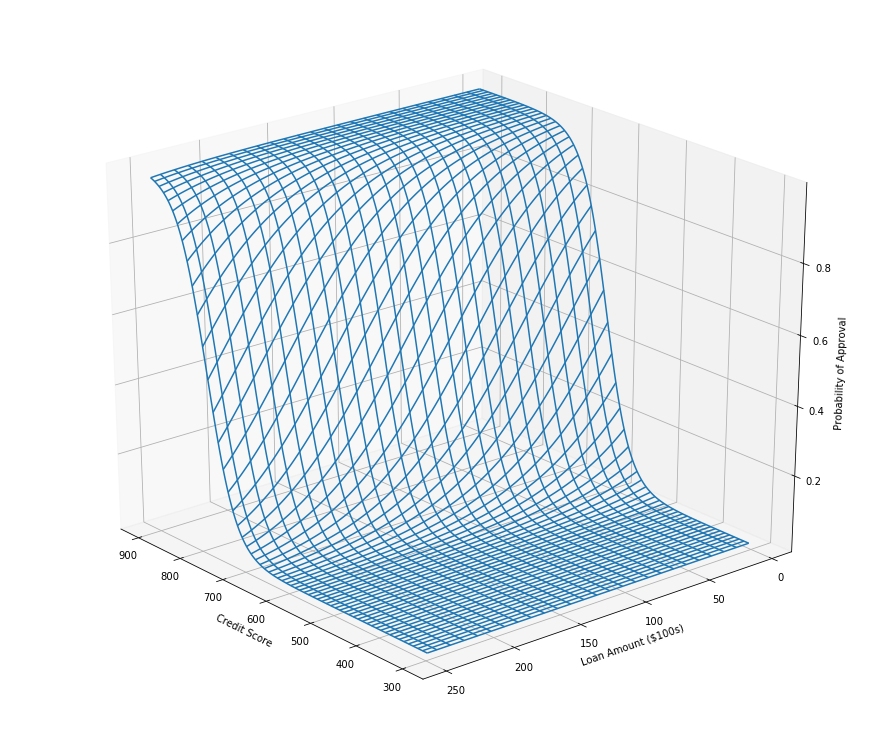

In [43]:
cr = np.arange(300,900,1)
am = np.arange(2,250,1)
xx, yy = np.meshgrid(cr, am)
Z = loans_model(xx,yy)
fig3d = m3d.Axes3D(plt.figure())
fig3d.plot_wireframe(xx, yy, Z, rstride=10, cstride=10);
fig3d.set_xlabel('Credit Score')
fig3d.set_ylabel('Loan Amount ($100s)')
fig3d.set_zlabel('Probability of Approval')
fig3d.view_init(25, 140)
plt.show();

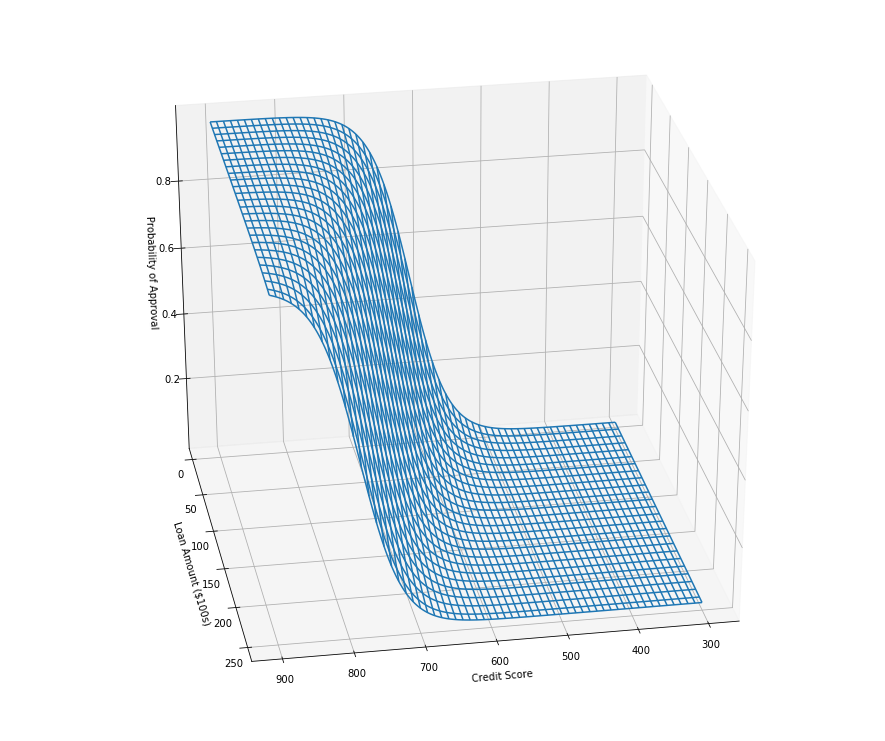

In [44]:
fig3d = m3d.Axes3D(plt.figure())
fig3d.plot_wireframe(xx, yy, Z, rstride=10, cstride=10);
fig3d.set_xlabel('Credit Score')
fig3d.set_ylabel('Loan Amount ($100s)')
fig3d.set_zlabel('Probability of Approval')
fig3d.view_init(30, 80)
plt.show();

So if, say, a customer had a credit score of 650 and was requesting a loan of \$2000, what does our model predict?

In [45]:
lgrg.predict([[650,20]])[0]

1

The prediction is that the loan will be approved, and we can determine the probability of approval with:

In [46]:
loans_model(650,20)

0.70197294162157575

NameError: name 'df100' is not defined

## Label Encoders and Dummy Variables

Before we look at the other classification techniques, we need to learn about ways to represent categorical data as numerical data.  Most of the scikit-learn modellers require numerical inputs, but we have a number of ways to convert data.

### Dummy Variables

Pandas comes with a way to encode categorical data as $0$ or $1$:  the `pd.get_dummies()` command will take a column (Series), and create a dataframe in which there is a column for each of the different entries in the original; the values for the column will be $1$ along the rows where that piece of data appeared, and $0$ otherwise.  For example, if we have a dataframe with one column consisting of colours:

In [53]:
c = pd.DataFrame({'Colour':['red','orange','yellow']})
c

,Colour
0,red
1,orange
2,yellow


then when we call `get_dummies` on the column `c['Colour']`, we get three columns (because there were three separate colours):

In [54]:
colour_dummies = pd.get_dummies(c['Colour'])
colour_dummies

,orange,red,yellow
0,0,1,0
1,1,0,0
2,0,0,1


We can reverse this (easily for a single column) by using the `idxmax` along columns (`axis=1`):

In [55]:
colour_dummies.idxmax(axis=1)

0       red
1    orange
2    yellow
dtype: object

Things become a little more complicated with labelling when we have more columns:

In [56]:
c['Shape'] = ['round','square','oblate spheroid']
c

,Colour,Shape
0,red,round
1,orange,square
2,yellow,oblate spheroid


In [57]:
pd.get_dummies(c)

,Colour_orange,Colour_red,Colour_yellow,Shape_oblate spheroid,Shape_round,Shape_square
0,0,1,0,0,1,0
1,1,0,0,0,0,1
2,0,0,1,1,0,0


To keep track of the separate columns, it prefixes the new column names with the old column name.  So, if this was the shape of data that we fed into our model, then if we wanted to test a prediction of something that was `yellow` and `round`, we could input the sequence `[0,0,1,0,1,0]`.

### Label Encoder

Sci-kit learn comes with a label-encoder, which allows for more compact conversion from categorical to numerical.  Instead of limited the outputs to only $0$ or $1$, a column which has $n$ distinct entries in it will have those values replaced by $0$ through $n-1$.  This way, no new columns are created.

In [61]:
#from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

We make an instance of the `preprocessing.LabelEncoder()` class, and then fit a given data set.

In [62]:
le = LabelEncoder()
le.fit(["red", "orange", "yellow"])

LabelEncoder()

We can reference the classes that it encoded:

In [63]:
list(le.classes_)

['orange', 'red', 'yellow']

Then we can take a new sequence of colours from the original list, and encode it with `.transform()`:

In [64]:
le.transform(['yellow','red','red'])

array([2, 1, 1])

This operation can easily be undone with `.inverse_transform()`:

In [66]:
list(le.inverse_transform([2, 2, 1]))

/Users/scotthsieh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['yellow', 'yellow', 'red']

One of the issues with the label encoder, however, is that it will only take 1-dimensional arrays as input.  If we wanted to apply the label encoder to a single column (such as in the dataframe `c` above):

In [67]:
lec = LabelEncoder()
lec.fit(c['Colour'])
list(lec.classes_)

['orange', 'red', 'yellow']

If we want to apply the label encoder to *all* of the columns at once, we need a slight workaround.  In this case, we will use `df.apply()` to apply the label encoder's `fit_transform` to the entire dataframe at once.  (You can find documentation here:
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html)

In [68]:
c.apply(lec.fit_transform)

,Colour,Shape
0,1,1
1,0,2
2,2,0


To perform the conversions back and forth, and to properly apply the labelling to future data, we need to make use of the `defaultdict`; it's a way for us to define a dictionary-like object to apply the rules of the encoding.  You can find more documentation here: https://docs.python.org/3/library/collections.html#collections.defaultdict

In [69]:
from collections import defaultdict

d = defaultdict(LabelEncoder)

We encode with:

In [70]:
fit = c.apply(lambda x: d[x.name].fit_transform(x))

In [71]:
fit

,Colour,Shape
0,1,1
1,0,2
2,2,0


And then can reverse the encoding:

In [72]:
fit.apply(lambda x: d[x.name].inverse_transform(x))

/Users/scotthsieh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/scotthsieh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/scotthsieh/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,Colour,Shape
0,red,round
1,orange,square
2,yellow,oblate spheroid


We can then use the dictionary to label future data `df` of the correct layout with the code `df.apply(lambda x: d[x.name].transform(x))`:

In [73]:
test = pd.DataFrame(columns = c.columns)
test.loc[0] = ['red','square']
test

,Colour,Shape
0,red,square


In [74]:
test.apply(lambda x: d[x.name].transform(x))

,Colour,Shape
0,1,2


This is most definitely not the only way to get around multi-column label encoding.  See this thread for other ideas (and also the ideas we used in this exercise!) https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn.

## Naive Bayes Classification

Naive Bayes is a set of machine learning algorithms for classifying data based on *features*.  The model is trained on a set of data containing features and labels, where the features are represented as vectors (and we often have to cleverly convert categorical data into numerical data for the modelling), and each label contains certain combinations of features.  The reason that is it called *naive* is that the models use the assumption that the features are independent of each other.

Recall from the statistics unit that Bayes' Theorem for conditional probability of $A$ given $B$ is:

$$  P(A\,|\,B) = \frac{P(B\,| \, A)P(A)}{P(B)} $$

The Naive Bayes classifier uses this formulation of probability to determine what *class* a given set of data belongs to, given previous data it has trained the model on.  Suppose we have classes $n$ many classes $C_1,C_2,\ldots,C_n$, and we represent the set of data to be classified as $\textbf{x} = \begin{bmatrix} x_1 & x_2 & \cdots & x_k\end{bmatrix}$.  The probability that the given data $\textbf{x}$ belongs to class $C_i$ is given by

$$ P(C_i\,|\,\textbf{x}) = \frac{P(C_i)P(\textbf{x}\,|\,C_i)}{P(\textbf{x})}$$

With the assumption that the features $\{x_i\}$ are independent of each other, it can be derived that the conditional probability $P(C_i\,|\,\textbf{x})$ is proportional to the product:

$$  P(C_i)P(x_1\,|\,C_i)P(x_2\,|\,C_i)\cdots P(x_k\,|\,C_i) = P(C_i)\prod_{j=1}^KP(x_j\,|\,C_i). $$

To use this probability setup to classify things, we need to pick a *decision rule*, i.e.: given the probabilities of $\textbf{x}$ for each of the classes $C_i$, which class do we pick?  In general, the most reasonable choice is to pick the one with the largest probability.

We will be using Scikit Learn's Naive Bayes package, which contains three main versions; the differences in use, broadly speaking, are:
*  **Gaussian Naive Bayes**. Suitable for continuous data, the assumption is that the likelihood of the features follows a Gaussian distribution.
*  **Multinomial Naive Bayes**. Suitable for data with discrete features, the feature vectors are comprised of probabilities of specific features being appearing in a sample of a class.
*  **Bernoulli Naive Bayes**.  Also suitable for discrete features, this version is for data with features that are binary-valued.

You can read the documentation here:
http://scikit-learn.org/stable/modules/naive_bayes.html

In [75]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

We'll first look at a small, theoretical example.  Suppose we had two features, each numerical that can vary continuously, and two classes called 'A' and 'B', with the following data:

In [76]:
thx = pd.DataFrame({'F1':[-1,-2,-2,-3,1,2,3],'F2':[0,-2,0,-2,1,2,1],'Class':['A','A','A','A','B','B','B']})
thx[['F1','F2','Class']]

,F1,F2,Class
0,-1,0,A
1,-2,-2,A
2,-2,0,A
3,-3,-2,A
4,1,1,B
5,2,2,B
6,3,1,B


Since the features vary continuously, and there are only two, we can visualise this with a 2d scatter plot:

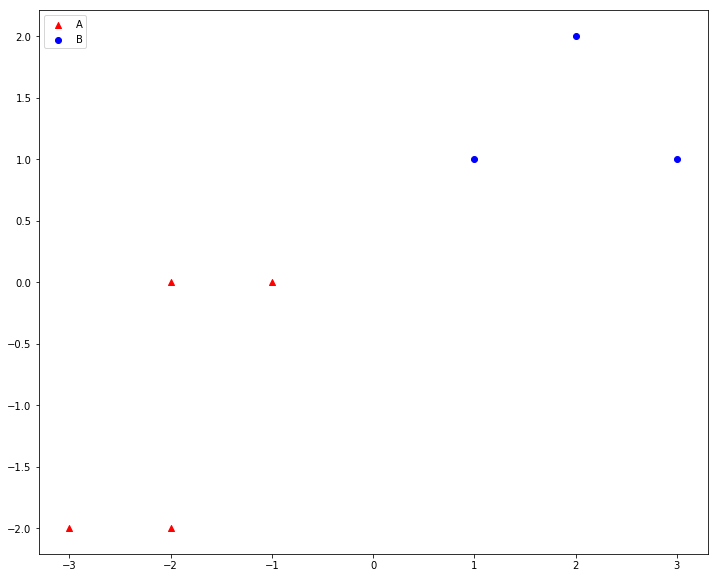

In [67]:
# Separate the two classes for easy of access
thxA = thx[thx['Class']=='A']
thxB = thx[thx['Class']=='B']
# Create scatter plot with legend
scatter(thxA['F1'],thxA['F2'],color='red',marker='^',label='A')
scatter(thxB['F1'],thxB['F2'],color='blue',marker='o',label='B')
plt.legend(loc=2);

We will feed the data into the our instance of the `GassianNB()` model, using the `.fit(X,Y)` method.  Here, the `X` will be the set of features (in our case, the columns `F1` and `F2`), and the `Y` will be the associated classes. 

In [77]:
X = thx[['F1','F2']]
Y = thx['Class']

gnb = GaussianNB()
gnb.fit(X, Y)

GaussianNB(priors=None)

Now that we have created the model, we can feed the `predict()` method a set of two numbers corresponding to the features, and have it predict which category that set of values belongs to.  Since we chose the Gaussian Naive Bayes method, assuming our data could vary continuously, we can use non-integer values.  Suppose we wanted to know which classes the points `(0.1,0.2)` and `(3,-0.5)` belong to.  Visually:

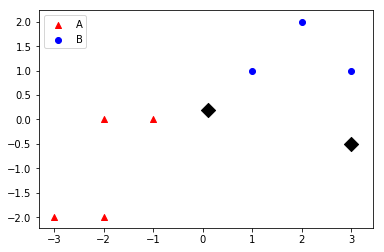

In [78]:
thxA = thx[thx['Class']=='A']
thxB = thx[thx['Class']=='B']
scatter(thxA['F1'],thxA['F2'],color='red',marker='^',label='A')
scatter(thxB['F1'],thxB['F2'],color='blue',marker='o',label='B')
scatter(0.1,0.2,color='black',marker='D',s=100)
scatter(3,-0.5,color='black',marker='D',s=100)
plt.legend(loc=2);

In [79]:
# We feed it numbers as a list of a list, owing to its expectation of the format of the input.
gnb.predict([[0.1,0.2]])

array(['A'], dtype='<U1')

In [80]:
gnb.predict([[3,-0.5]])

array(['B'], dtype='<U1')

With the predicted points:

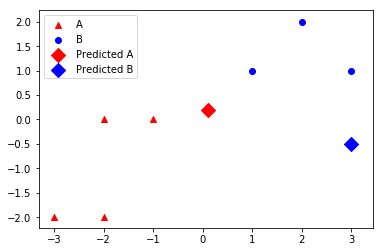

In [81]:
thxA = thx[thx['Class']=='A']
thxB = thx[thx['Class']=='B']
scatter(thxA['F1'],thxA['F2'],color='red',marker='^',label='A')
scatter(thxB['F1'],thxB['F2'],color='blue',marker='o',label='B')
scatter(0.1,0.2,color='red',marker='D',s=100,label='Predicted A')
scatter(3,-0.5,color='blue',marker='D',s=100,label='Predicted B')
plt.legend(loc=2);

So the model predicted that `(0.1,0.2)` belongs to class `A`, and `(3,-0.5)` belongs to class `B`.  Based on the small number of data points, and the strong visual separation between the two classes, we can see that this is not an unreasonable classification.

### Classifying Entirely Categorical Data
Let's look at some data for different kinds of fruits, based on their colour, size, and the type of flesh they have; the categories are the families the fruits belong to.

In [82]:
fruits = pd.DataFrame({'Colour':['red','orange','yellow','red','green','blue'],
 'Size':['medium','medium','medium','small','medium','small'],
 'Flesh':['solid','segmented','segmented','solid','solid','solid'],
 'Category':['pomaceous','citrus','citrus','berry','pomaceous','berry']},
 index=['apple','orange','lemon','strawberry','pear','blueberry'])
fruits

,Colour,Size,Flesh,Category
apple,red,medium,solid,pomaceous
orange,orange,medium,segmented,citrus
lemon,yellow,medium,segmented,citrus
strawberry,red,small,solid,berry
pear,green,medium,solid,pomaceous
blueberry,blue,small,solid,berry


For this kind of data, we'll use Bernoulli Naive Bayes:
>Like MultinomialNB, this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.

We need to convert the categorical data into numerical data that the program can understand.  For example, there are only two sizes (medium and small), so we can represent the "size" as a 0 or 1, corresponding to small or medium, respectively.  The same can be done for segmented or solid flesh.  Since the colour attribute has more than 2 values, we'll use the `pd.get_dummies` to encode (as seen previously).

In [83]:
colour_dummies = pd.get_dummies(fruits.Colour, prefix='Colour')

In [84]:
fruits['size_n'] = fruits.Size.map({'small':0, 'medium':1})
fruits['flesh_n'] = fruits.Flesh.map({'segmented':0,'solid':1})

In [85]:
# We'll create a dataframe of just the binary feature data
fr = pd.concat([fruits[['size_n','flesh_n']],colour_dummies],axis=1)

In [86]:
fr

,size_n,flesh_n,Colour_blue,Colour_green,Colour_orange,Colour_red,Colour_yellow
apple,1,1,0,0,0,1,0
orange,1,0,0,0,1,0,0
lemon,1,0,0,0,0,0,1
strawberry,0,1,0,0,0,1,0
pear,1,1,0,1,0,0,0
blueberry,0,1,1,0,0,0,0


In [87]:
fnb = BernoulliNB()
#fnb.fit(fr.values, fruits['Category'])
fnb.fit(fr, fruits['Category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

Now that we've created our model, let's see how well we can predict a few other fruit:<br>
Predict a kumquat?  

In [88]:
# Small, orange, segmented.
kumquat = [[1,0,0,0,1,0,0]]
fnb.predict(kumquat)

array(['citrus'], dtype='<U9')

Predict a green apple?  

In [89]:
# Medium, green, solid:
green_apple = [[1,1,0,1,0,0,0]]
fnb.predict(green_apple)

array(['pomaceous'], dtype='<U9')

Grape?  

In [81]:
# Small, green, solid
grape = [[0,1,0,1,0,0,0]]
fnb.predict(grape)

array(['berry'], 
      dtype='<U9')

So with very few data points to start with, our model can successfully categorize a number of other fruit.  The limitation, though, is for features/catgories that are not present:  we couldn't use this model to predict, say, a grapefruit, because its size would be "large", which isn't accounted for in the model of the original data.  Similarly, we couldn't properly classify a pumpkin, because we didn't train our model on any data that included gourds as a class.  

The model is also not perfect; it cannot, for example, classify a pomegranate properly (which is technically a berry), because it thinks it is a citrus fruit (which it definitely is not). 

In [82]:
# Medium, segmented, red
pomegranate = [[1,0,0,0,0,1,0]]
fnb.predict(pomegranate)

array(['citrus'], 
      dtype='<U9')

# Decision Trees

Decision trees will be familiar to anyone who has played 20 Questions:  one player thinks of something (a person, an object, a place, etc.), and the other player tries to guess what it is by asking up to 20 questions that have yes or no answers.  Based on the answers you receive, you're able to eliminate many possible solutions (e.g.: if the answer to "animal?" is "yes", but the answer to "does it have four legs?" is "no", then clearly it cannot be a pig, or a sheep, or a cow, or a dog, or...), and hopefully arrive at the answer.  This is an example of a *binary* tree, as there are two possible brances to each question:

<img src="https://i.imgur.com/uHGgrbO.png",width=700,height=700>

The tree is made up of *nodes* (with the first being the *root* node), and each node represents a test on the attributes (e.g.: is the colour 'red'?).  Based on what the answer is, the nodes branch into child nodes that perform further tests until you reach a *leaf* node (or *terminal* node) that has no child nodes.  

How does the tree decide to make splits?  The goal is to split the data such that we *gain* information about the subsets we've created.  In essence, we want to reduce the uncertainty or randomness in the collections of data; without introducing too much information theory, the measure of this uncertainty is the *entropy*, defined as:

$$ H = -\sum_{c\in C} P(c)\log_2(P(c))$$ 

where $P(c)$ is the probability of occurrence of the class $c$ from the set of classes $C$ (as a note, the choice of $\log_2$ -- making the entropy measured in *bits* -- as a choice; other common choices including $\ln$ or $\log_{10}$).  The decision looks at possible ways to split the data, and chooses the one which maximizes the information gain.  In other words, the choice which most reduces the entropy.

One of the other ways we can measure this is the *Gini impurity*, which is a way to measure the following question: "Suppose you select an element of the data at random, and then assign it a random class from the list of classes; how often will this result in an *incorrect* labelling?".  If we have $N$ classes, and we define $p_i$ to be the proportion of elements of our data that are labelled as being in class $i\in\{1,2,\ldots,N\}$, then the Gini impurity is defined as

$$ I_G = 1 - \sum_{i=1}^N{p_i}^2. $$

Decision tree learning can be used for classification and regression:  just like our regression models and our classification algorithms, the decision tree will be trained on given data to create a model that we can use to predict new data with (either what *category* it belongs to, or to predict a *number* output like the price of a house based on other features, like from the first unit).  

We can implement a simple decision tree model using sklearn's `tree` object.  

In [83]:
from sklearn import tree

Let's look at the following data about animals:

In [84]:
an = pd.read_csv('animals.csv',index_col=0)
an

,Legs,Cold or Warm Blooded,Covering,Aquatic,Aerial,Lays Eggs,Category
Tree Frog,4,cold,none,partial,no,yes,amphibian
Cane Toad,4,cold,none,no,no,yes,amphibian
Ball Python,0,cold,scales,no,no,yes,reptile
Dove,2,warm,feathers,no,yes,yes,bird
Human,2,warm,hair,no,no,no,mammal
Lion,4,warm,fur,no,no,no,mammal
Chihuaha,4,warm,fur,no,no,no,mammal
Crow,2,warm,feathers,no,yes,yes,bird
Monitor Lizard,4,cold,none,no,no,yes,reptile
Veiled Chameleon,4,cold,scales,no,no,yes,reptile


We will make an instance of the `tree.DecisionTreeClassifier()` class and use the `.fit(X,Y)` method with `X` being the features, and `Y` the categories. 

In [85]:
animals = tree.DecisionTreeClassifier()
animals

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [86]:
an.Category.unique() #lists all levels in category

array(['amphibian', 'reptile', 'bird', 'mammal'], dtype=object)

This time we will use the label encoder to convert our non-numerical data, and concatenate them all together:

In [87]:
le = LabelEncoder()
an1 = (an[['Cold or Warm Blooded','Covering','Aquatic','Aerial','Lays Eggs']]).apply(lambda x: d[x.name].fit_transform(x))
an1

,Cold or Warm Blooded,Covering,Aquatic,Aerial,Lays Eggs
Tree Frog,0,3,1,0,1
Cane Toad,0,3,0,0,1
Ball Python,0,4,0,0,1
Dove,1,0,0,1,1
Human,1,2,0,0,0
Lion,1,1,0,0,0
Chihuaha,1,1,0,0,0
Crow,1,0,0,1,1
Monitor Lizard,0,3,0,0,1
Veiled Chameleon,0,4,0,0,1


In [88]:
an_encoded = pd.concat([an['Legs'],an1],axis=1)
an_encoded #all numerical data concatenated together


,Legs,Cold or Warm Blooded,Covering,Aquatic,Aerial,Lays Eggs
Tree Frog,4,0,3,1,0,1
Cane Toad,4,0,3,0,0,1
Ball Python,0,0,4,0,0,1
Dove,2,1,0,0,1,1
Human,2,1,2,0,0,0
Lion,4,1,1,0,0,0
Chihuaha,4,1,1,0,0,0
Crow,2,1,0,0,1,1
Monitor Lizard,4,0,3,0,0,1
Veiled Chameleon,4,0,4,0,0,1


In [89]:
# Fit the model
animals.fit(an_encoded, an['Category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Now let's see if it can predict some animals, like the naked mole rat, or the giant tortoise:

In [90]:
naked_mole_rat = [[4,1,3,0,0,0]] #'Legs', 'Cold or Warm Blooded','Covering','Aquatic','Aerial','Lays Eggs'
animals.predict(naked_mole_rat)

array(['mammal'], dtype=object)

In [91]:
giant_tortoise = [[4,0,4,0,0,1]]
animals.predict(giant_tortoise)

array(['reptile'], dtype=object)

Indeed it does!  What about a really weird choice, like a platypus?  They are warm-blooded, semi-aquatic, egg-laying mammals that have fur.

In [92]:
platypus = [[4,1,1,1,0,1]]
animals.predict(platypus)

array(['bird'], dtype=object)

It mislabels the platypus as a *bird*, interestingly.  Still, the platypus can be considered a very strange edge case...

### Fruit Classification Revisited

Let's revisit the fruit-classification problem from earlier:

In [93]:
fruits

,Category,Colour,Flesh,Size,size_n,flesh_n
apple,pomaceous,red,solid,medium,1,1
orange,citrus,orange,segmented,medium,1,0
lemon,citrus,yellow,segmented,medium,1,0
strawberry,berry,red,solid,small,0,1
pear,pomaceous,green,solid,medium,1,1
blueberry,berry,blue,solid,small,0,1


This time, instead of using `.get_dummies()` like we did for Naive Bayes, we're going to use the label encoding.  We only need to encode the features (colour, flesh, and size):

In [94]:
le = LabelEncoder()
fr = (fruits[['Colour','Flesh','Size']]).apply(lambda x: d[x.name].fit_transform(x))
fr

,Colour,Flesh,Size
apple,3,1,0
orange,2,0,0
lemon,4,0,0
strawberry,3,1,1
pear,1,1,0
blueberry,0,1,1


Again, we make an instance of the `DecisionTreeClassifier()` class:

In [95]:
ftr = tree.DecisionTreeClassifier()
ftr.fit(fr, fruits['Category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

We can see if this model can accurately predict a kumquat.  (Orange, segmented, small) translates to `[2,0,0]` in this case:

In [96]:
kumquat = [[2,0,0]] #'Colour','Flesh','Size'
ftr.predict(kumquat)

array(['citrus'], dtype=object)

### Tree Visualization

We can visualize the tree that was constructed, but we'll need to install two new packages for visualization, including a proper program.  Follow these steps:
1. Download Graphviz for your operating system: https://graphviz.gitlab.io/download/
2.  From the Anacona prompt, run `conda install graphviz`
3.  Then run `conda install pydotplus`

In [97]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# On Windows, Graphviz no longer adds itself to the PATH in Windows.  
# This code accomplishes it (temporarily)
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

ModuleNotFoundError: No module named 'pydotplus'

In [ ]:
dot_data = StringIO()
export_graphviz(ftr, out_file=dot_data, feature_names=fr.columns, class_names= ftr.classes_, 
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Visualizing this graph shows us a very interesting thing:  despite the fact that we have 3 features, there are only *two* splits.  The most useful features to split along it found were size and flesh; once it had done this, it had successfully compartmentalized the training data (this is a result of the training data set being incredibly small).  As a result, it does not take into account colour at all.  We can see this by varying the colour attribute when feeding it to the `.predict()` method:

In [ ]:
print('Red kumquat predicted to be',ftr.predict([[3,0,0]]))
print('Blue kumquat predicted to be',ftr.predict([[0,0,0]]))
print('Yellow kumquat predicted to be',ftr.predict([[4,0,0]]))
print('Green kumquat predicted to be',ftr.predict([[1,0,0]]))
print('Orange kumquat predicted to be',ftr.predict([[2,0,0]]))

The best way around this loss of feature is to expand the original training set, which we will be doing in the exercises.

We can also view the animals tree:

In [ ]:
dot_data = StringIO()
export_graphviz(animals, out_file=dot_data, feature_names=an_encoded.columns, class_names= animals.classes_, 
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

What can we glean from looking at this tree?  What node decision caused the (understandable) mislabelling of the platypus?  Despite the fact that birds are the *only* animal with feathers, what features does our tree use to determine if the given animal is a bird?

## Making Decision Trees Better

While decision trees are easy to understand, they have a number of shortcomings.  Decision trees tend to be very sensitive to minor changes in data, and can introduce serious biases as you move further down the tree (because you're considering smaller subsets of the training data at each level down).  One way to get around these limitations is by considering an ensemble method of trees, such as *random forests*.  We will be speaking more about these in Unit 10.

# Assignment 8

1. 1. Load in the `additional_fruits.csv` file, and concatenate it with the original fruits collection.  (Note: raspberries are listed as having solid flesh; the argument is that raspberries are an *aggregate fruit*, composed of an external collection "drupes", each of which have solid flesh.  This is in contrast to the citrus fruit which have segmented internal flesh, and as we'll see shortly, pomegranates -- which also have internal segmented flesh.)
   2. Re-model the data set using the `BernoulliNB`, and see if it can correctly predict red finger bananas (red, small, solid -berry), pomegranates (red,medium,segmented -- berry), black currants (blue,small,solid - berry), mango (orange,medium,solid - berry), and red finger limes (red, small, segmented -- citrus).
   3. Re-model the new data set using a decision tree.  Compare the visualization of this decision tree to the old model; does this model now use the colour feature?  
   4. Predict all of the fruits from part B., and compute the percentage change in model accuracy from the Naive Bayes model in B. to this decision tree model.
2. 1. The classification models for the animals we did had trouble with a platypus, as it's a very strange edge case in the mammal family.  Load in the `Unit8_additional_animals.csv`; it contains a number of mammals that share some properties with the platypus. Concatenate it with the original `animals.csv`, and use the label encoder on this new dataframe.
   2. Create new Naive Bayes and Decision Tree models for the larger set of animals.   Are they able to successfully classify a platypus?
   3. Visualize the new decision tree, and compare it to the old model decision tree.  What changes to the decision structure came about because of the new data?

# Assignment Questions and Answers


## Question 1: Logistic Regression with Loan Data ##
1. Here is a dataset containing loans that have either made a first payment default (IsDefault = 1) or not (IsDefault = 0). There are various independent variables that can help us predict whether a customer will default or not. Given this dataset containing loans, predict default rate using logistic regression. 
    1. What are the general summary statistics of this data set? Number of rows? Columns? What is the overall default rate of the dataset (i.e., sum of IsDefault = 1 divided by total number of rows)?
    2. Look at the correlations between IsDefault and the independent variables. Which 3 variables have the strongest correlation with IsDefault? 
    3. Visualize the relationship between bank score and default rate.
    4. Build a logistic regression model using bank score to predict default rate. What are the coefficient and intercept values? Plot the logistic function.
    5. What is the probability that a lead with a bank score of 800 will default? What about 500? 
    6. Build a logistic regression model with multiple features from this data set. 

In [251]:
LoanData = pd.read_csv('LoanData.csv',index_col=0) #reading in the csv file

LoanData.head(10) #taking a look at the first 10 rows

,IsDefault,is_no_bank_call,payfrequency,NumOfDigitsInEmailUsername,FraudScore,IsCheapCampaign,lead_cost,loantoincome,bankmonths,requestedamount,...,BankScore2,BankScore,n_months_address,IsHurricaneHarvey,DistFromAddressBucket,AddressContactScore,EmailContactScore,PhoneContactScore,ssn_to_bankaccount,PhoneCarrier
id,,,,,,,,,,,,,,,,,,,,,
1,0,False,B,0,500,No,40,13.79,0.0,500,...,699,765,120,True,c_10to25,2,3.0,1,2,US
2,0,False,B,6,500,No,40,20.00,0.0,500,...,746,896,12,True,c_10to25,3,1.0,3,3,Sprint
3,0,True,B,4,500,No,40,25.00,3.0,500,...,703,489,120,False,c_10to25,1,1.0,1,3,Sprint
4,1,False,B,1,501,No,20,11.15,0.0,300,...,600,674,0,False,a_less3,3,2.0,3,0,Metro PCS
5,0,False,B,0,502,No,40,10.00,9.0,500,...,571,546,48,True,NONE,4,3.0,3,2,US
6,0,False,B,4,502,No,40,40.00,0.0,1000,...,682,737,48,False,a_less3,3,1.0,1,0,Sprint
7,1,False,B,0,502,No,40,16.67,6.0,500,...,531,568,24,False,d_25to300,3,2.0,1,3,Sprint
8,0,False,B,0,502,No,40,8.33,0.0,500,...,752,716,24,False,NONE,3,2.0,3,1,Verizon Wireless
9,1,False,B,0,503,No,20,6.67,0.0,200,...,685,841,12,False,c_10to25,3,1.0,1,2,Sprint


In [160]:
len(LoanData) #number of rows

2481

In [161]:
LoanData.shape #number of rows and columns

(2481, 25)

In [163]:
LoanData.loc[LoanData['IsDefault'] == 1, 'IsDefault'].sum() #num defaults

554

In [164]:
(LoanData.loc[LoanData['IsDefault'] == 1, 'IsDefault'].sum() / len(LoanData)) * 100 #default rate

22.329705763804917

In [165]:
LoanData.corr() #correlations between IsDefault and other variables #FraudScore, BankScore2, and BankScore have the strongest correlations

,IsDefault,is_no_bank_call,NumOfDigitsInEmailUsername,FraudScore,lead_cost,loantoincome,bankmonths,requestedamount,netmonthly,bankyears,BankScore2,BankScore,n_months_address,IsHurricaneHarvey,AddressContactScore,EmailContactScore,PhoneContactScore,ssn_to_bankaccount
IsDefault,1.000000,-0.051420,0.045777,-0.111653,0.013802,0.035915,0.018820,0.032958,0.009138,-0.022245,-0.086131,-0.095757,0.012792,-0.043111,0.042023,0.018311,0.024060,0.046633
is_no_bank_call,-0.051420,1.000000,-0.033884,0.401012,-0.005182,-0.094848,0.008014,0.006841,0.075051,0.058949,0.346242,0.398075,0.045359,0.011870,-0.104212,-0.040170,-0.141550,0.024895
NumOfDigitsInEmailUsername,0.045777,-0.033884,1.000000,-0.059577,-0.053109,0.010366,-0.009839,-0.034466,-0.057066,-0.023307,-0.030296,-0.032130,0.015042,-0.009430,-0.019773,0.062860,-0.001894,-0.024551
FraudScore,-0.111653,0.401012,-0.059577,1.000000,-0.011877,0.003244,-0.017070,0.116637,0.101150,0.063951,0.252346,0.310600,0.085022,0.059823,-0.136906,0.021786,-0.078239,-0.157256
lead_cost,0.013802,-0.005182,-0.053109,-0.011877,1.000000,-0.204157,0.034191,-0.270406,-0.008728,-0.035589,0.029347,-0.027714,0.013226,0.024257,-0.048672,-0.049439,-0.027081,0.057901
loantoincome,0.035915,-0.094848,0.010366,0.003244,-0.204157,1.000000,-0.087560,0.689689,-0.378049,0.088271,-0.035663,0.042956,0.079081,0.003434,0.066956,0.095803,0.043497,-0.160243
bankmonths,0.018820,0.008014,-0.009839,-0.017070,0.034191,-0.087560,1.000000,-0.083254,0.025367,-0.189058,-0.020762,-0.060760,0.118410,-0.003024,-0.031832,-0.070266,-0.001418,0.124962
requestedamount,0.032958,0.006841,-0.034466,0.116637,-0.270406,0.689689,-0.083254,1.000000,0.078364,0.147934,0.042458,0.074130,0.149710,0.017512,-0.003033,0.029631,-0.008303,-0.139037
netmonthly,0.009138,0.075051,-0.057066,0.101150,-0.008728,-0.378049,0.025367,0.078364,1.000000,0.006526,0.066381,0.008348,0.003120,0.033903,-0.057129,-0.054948,-0.066047,0.024525
bankyears,-0.022245,0.058949,-0.023307,0.063951,-0.035589,0.088271,-0.189058,0.147934,0.006526,1.000000,0.152880,0.122192,0.181177,0.016229,-0.015590,0.023125,-0.042495,-0.029710


In [166]:
LoanData.dtypes #getting the data types of each column

IsDefault                       int64
is_no_bank_call                  bool
payfrequency                   object
NumOfDigitsInEmailUsername      int64
FraudScore                      int64
IsCheapCampaign                object
lead_cost                       int64
loantoincome                  float64
bankmonths                    float64
requestedamount                 int64
netmonthly                      int64
FraudScoreBucketSmall          object
BankBehaviorBucketSmall        object
bankyears                       int64
incometype                     object
BankScore2                      int64
BankScore                       int64
n_months_address                int64
IsHurricaneHarvey                bool
DistFromAddressBucket          object
AddressContactScore             int64
EmailContactScore             float64
PhoneContactScore               int64
ssn_to_bankaccount              int64
PhoneCarrier                   object
dtype: object

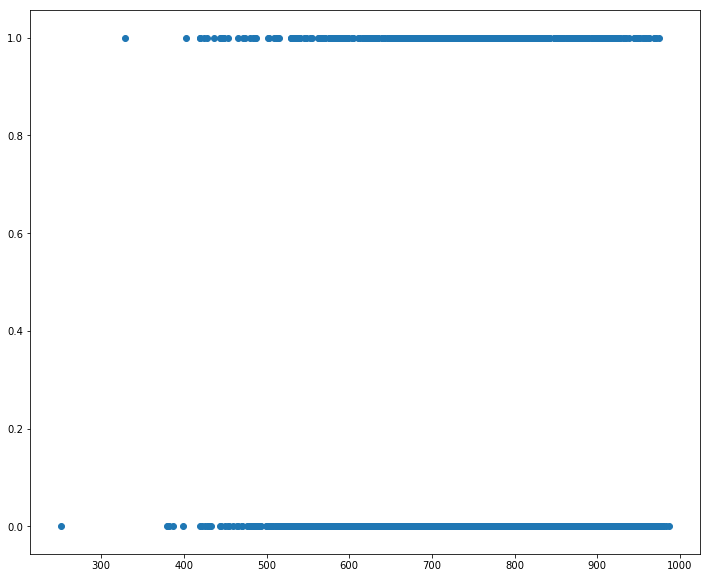

In [167]:
scatter(LoanData['BankScore'],LoanData['IsDefault']); #relationship between BankScore and IsDefault

In [168]:
LoanData['BankScore'].head(10)

id
1     765
2     896
3     489
4     674
5     546
6     737
7     568
8     716
9     841
10    622
Name: BankScore, dtype: int64

In [169]:
LoanData['IsDefault'].head(10)

id
1     0
2     0
3     0
4     1
5     0
6     0
7     1
8     0
9     1
10    1
Name: IsDefault, dtype: int64

In [170]:
#Logistic regression model with BankScore
lgrg1 = linear_model.LogisticRegression(solver='newton-cg')
X = LoanData['BankScore'].values.reshape(-1,1)
Y = LoanData['IsDefault']
lgrg1.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [171]:
#BankScore coefficient
lead_cost_coef = lgrg1.coef_[0][0]
lgrg1.coef_[0][0]

-0.0018645585960473967

In [172]:
#Interceipt
lead_cost_intercept = lgrg1.intercept_[0]
lgrg1.intercept_[0]

0.17107534574062525

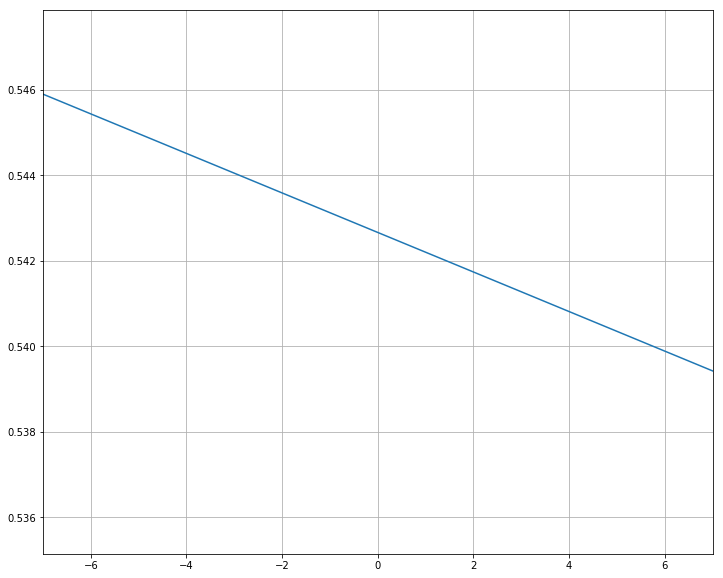

In [173]:
#Plotting the logistic function
a = lgrg1.coef_[0][0]
b = lgrg1.intercept_[0]
plt.plot(x,special.expit(a*x+b))
plt.grid()
plt.xlim(-7,7);

In [174]:
test_data = [500,800]
predict_lead_cost = pd.DataFrame({'Bank Score':test_data,'Prob. of Default':[special.expit(a*x+b) for x in test_data]})
predict_lead_cost

,Bank Score,Prob. of Default
0,500,0.318385
1,800,0.210723


In [175]:
lgrg1.predict([[800]])[0]

0

In [176]:
#Multiple logistic regression with netmonthly and requestedamount

lgrg2 = linear_model.LogisticRegression(solver='newton-cg')
X = LoanData[['netmonthly','requestedamount']]
Y = LoanData['IsDefault']
lgrg2.fit(X,Y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [177]:
LoanData['netmonthly'].head(10)

id
1     3625
2     2500
3     2000
4     2691
5     5000
6     2500
7     3000
8     6000
9     3000
10    3000
Name: netmonthly, dtype: int64

In [178]:
LoanData['requestedamount'].head(10)

id
1      500
2      500
3      500
4      300
5      500
6     1000
7      500
8      500
9      200
10    1000
Name: requestedamount, dtype: int64

In [179]:
LoanData_netmonthly_coeff = lgrg2.coef_[0][0]
LoanData_netmonthly_coeff

6.9651764400972503e-06

In [180]:
LoanData_requestedamount_coeff = lgrg2.coef_[0][1]
LoanData_requestedamount_coeff

0.00020278505594073995

In [182]:
LoanData_intercept = lgrg2.intercept_[0]
LoanData_intercept

-1.4035791387620309

In [183]:
b1,b2 = lgrg2.coef_[0]
b0 = lgrg2.intercept_[0]
print(b1)
print(b2)
print(b0)

6.9651764401e-06
0.000202785055941
-1.40357913876


In [184]:
def LoanData_model(netmonthly,requestedamount): #building model
    return special.expit(netmonthly*b1+requestedamount*b2+b0)

In [185]:
#prediction using our model for netmonthly of 1000 and requesting 500
lgrg2.predict([[1000,500]])[0] 

0

## Question 2: Decision Trees with Loan Data ##

2. Now let's predict defaults using decision trees. 
    1. How many different levels are in the dependent variable/factor (IsDefault)?
    2. Use the label encoder to encode the variables. 
    3. Using your decision tree model, will a customer with a Bank Score of 800, is no bank call = 0, payfrequency = B, and a FraudScoreBucketSmall = a_less719 default?

In [252]:
LoanDatatree = tree.DecisionTreeClassifier()
LoanDatatree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [187]:
LoanData.dtypes

IsDefault                       int64
is_no_bank_call                  bool
payfrequency                   object
NumOfDigitsInEmailUsername      int64
FraudScore                      int64
IsCheapCampaign                object
lead_cost                       int64
loantoincome                  float64
bankmonths                    float64
requestedamount                 int64
netmonthly                      int64
FraudScoreBucketSmall          object
BankBehaviorBucketSmall        object
bankyears                       int64
incometype                     object
BankScore2                      int64
BankScore                       int64
n_months_address                int64
IsHurricaneHarvey                bool
DistFromAddressBucket          object
AddressContactScore             int64
EmailContactScore             float64
PhoneContactScore               int64
ssn_to_bankaccount              int64
PhoneCarrier                   object
dtype: object

In [188]:
LoanData.IsDefault.unique() #lists all levels in category

array([0, 1])

In [190]:
le = LabelEncoder()
LoanData1 = (LoanData[['is_no_bank_call','payfrequency','FraudScoreBucketSmall']]).apply(lambda x: d[x.name].fit_transform(x))
LoanData1.head(10)

,is_no_bank_call,payfrequency,FraudScoreBucketSmall
id,,,
1,0,0,0
2,0,0,0
3,1,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,0,0
9,0,0,0


In [203]:
LoanData_encoded = pd.concat([LoanData['BankScore'],LoanData1],axis=1)
LoanData_encoded.head(10) #all numerical data concatenated together

,BankScore,is_no_bank_call,payfrequency,FraudScoreBucketSmall
id,,,,
1,765,0,0,0
2,896,0,0,0
3,489,1,0,0
4,674,0,0,0
5,546,0,0,0
6,737,0,0,0
7,568,0,0,0
8,716,0,0,0
9,841,0,0,0


In [204]:
LoanDatatree.fit(LoanData_encoded, LoanData['IsDefault'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [205]:
LoanData_encoded.head(10)

,BankScore,is_no_bank_call,payfrequency,FraudScoreBucketSmall
id,,,,
1,765,0,0,0
2,896,0,0,0
3,489,1,0,0
4,674,0,0,0
5,546,0,0,0
6,737,0,0,0
7,568,0,0,0
8,716,0,0,0
9,841,0,0,0


In [206]:
LoanData_encoded.payfrequency.unique() #lists all levels in category

array([0, 1, 2])

In [207]:
payfreq_tab = pd.crosstab(index=LoanData_encoded["payfrequency"],columns="count")
payfreq_tab

col_0,count
payfrequency,
0,1805
1,557
2,119


In [208]:
LoanData_encoded = LoanData_encoded.rename(columns={'payfrequency': 'payfrequency_encoded', 'is_no_bank_call': 'is_no_bank_call_encoded', 'FraudScoreBucketSmall': 'FraudScoreBucketSmall_encoded'})
LoanData_encoded.head(10)

,BankScore,is_no_bank_call_encoded,payfrequency_encoded,FraudScoreBucketSmall_encoded
id,,,,
1,765,0,0,0
2,896,0,0,0
3,489,1,0,0
4,674,0,0,0
5,546,0,0,0
6,737,0,0,0
7,568,0,0,0
8,716,0,0,0
9,841,0,0,0


In [210]:
pd.crosstab(index=LoanData_encoded["payfrequency_encoded"], columns=LoanData["payfrequency"])

payfrequency,B,S,W
payfrequency_encoded,,,
0,1805,0,0
1,0,557,0
2,0,0,119


In [211]:
pd.crosstab(index=LoanData_encoded["is_no_bank_call_encoded"], columns=LoanData["is_no_bank_call"])

is_no_bank_call,False,True
is_no_bank_call_encoded,,
0,1606,0
1,0,875


In [199]:
pd.crosstab(index=LoanData_encoded["FraudScoreBucketSmall_encoded"], columns=LoanData["FraudScoreBucketSmall"])

FraudScoreBucketSmall,a_less719,b_720to799,c_great800
FraudScoreBucketSmall_encoded,,,
0,1798,0,0
1,0,517,0
2,0,0,166


In [212]:
example_lead = [[800,0,0,0]]  #Bank Score of 800, is no bank call of 0, payfrequency of B, FraudScoreBucketSmall = a_less719
LoanDatatree.predict(example_lead)

array([0])

## Question 3: Decision Trees with Retail Data ##

3. This retail data set tells us what types of customer segments ordered certain items and describes the cost of those items. Based on the values of the variables given to us, let's build a decision tree model to predict which customer segment an order is likely to come from based on its characteristics.
    1. Take a look at your data. Give some basic summary statistics.
    2. How many different levels are in the dependent variable/factor (Segment)?
    3. Use the label encoder to encode the variables. 
    4. Using your decision tree model, predict the customer segment when the independent variables equal certain values. Try out a few to see how the model changes the output.

In [253]:
#Retail Data
Retail = pd.read_csv('Retail_Data.csv',index_col=0)
Retail.head(10)


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
Row ID,,,,,,,,,,,,,,,,,,,,,
32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
47221,SG-2013-4320,2013-11-05,2013-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical
22732,IN-2013-42360,2013-06-28,2013-07-01,Second Class,JM-15655,Jim Mitchum,Corporate,Sydney,New South Wales,Australia,...,TEC-PH-10000030,Technology,Phones,"Samsung Smart Phone, with Caller ID",2862.675,5,0.1,763.2750,897.35,Critical
30570,IN-2011-81826,2011-11-07,2011-11-09,First Class,TS-21340,Toby Swindell,Consumer,Porirua,Wellington,New Zealand,...,FUR-CH-10004050,Furniture,Chairs,"Novimex Executive Leather Armchair, Adjustable",1822.080,4,0.0,564.8400,894.77,Critical
31192,IN-2012-86369,2012-04-14,2012-04-18,Standard Class,MB-18085,Mick Brown,Consumer,Hamilton,Waikato,New Zealand,...,FUR-TA-10002958,Furniture,Tables,"Chromcraft Conference Table, Fully Assembled",5244.840,6,0.0,996.4800,878.38,High
40155,CA-2014-135909,2014-10-14,2014-10-21,Standard Class,JW-15220,Jane Waco,Corporate,Sacramento,California,United States,...,OFF-BI-10003527,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,5083.960,5,0.2,1906.4850,867.69,Low


In [240]:
Retail.dtypes

Order ID           object
Order Date         object
Ship Date          object
Ship Mode          object
Customer ID        object
Customer Name      object
Segment            object
City               object
State              object
Country            object
Market             object
Region             object
Product ID         object
Category           object
Sub-Category       object
Product Name       object
Sales             float64
Quantity            int64
Discount          float64
Profit            float64
Shipping Cost     float64
Order Priority     object
dtype: object

In [244]:
Retail.Segment.unique() #lists all levels in category

array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

In [254]:
le = LabelEncoder()
Retail1 = (Retail[['Ship Mode','Market','Region','Category','Sub-Category','Order Priority']]).apply(lambda x: d[x.name].fit_transform(x))
Retail1.head(10)

,Ship Mode,Market,Region,Category,Sub-Category,Order Priority
Row ID,,,,,,
32298,1,6,6,2,0,0
26341,2,0,9,0,5,0
25330,0,0,9,2,13,3
13524,0,4,3,2,13,3
47221,1,1,0,2,6,0
22732,2,0,9,2,13,0
30570,0,0,9,0,5,0
31192,3,0,9,0,16,1
40155,3,6,12,1,3,2


In [246]:
Retail_encoded = Retail1.rename(columns={'Ship Mode': 'Ship Mode Encoded','Market': 'Market Encoded','Region': 'Region Encoded','Category': 'Category Encoded','Sub-Category': 'Sub-Category Encoded','Order Priority': 'Order Priority Encoded'})
Retail_encoded.head(10)

,Ship Mode Encoded,Market Encoded,Region Encoded,Category Encoded,Sub-Category Encoded,Order Priority Encoded
Row ID,,,,,,
32298,1,6,6,2,0,0
26341,2,0,9,0,5,0
25330,0,0,9,2,13,3
13524,0,4,3,2,13,3
47221,1,1,0,2,6,0
22732,2,0,9,2,13,0
30570,0,0,9,0,5,0
31192,3,0,9,0,16,1
40155,3,6,12,1,3,2


In [247]:
Retailtree = tree.DecisionTreeClassifier()
Retailtree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [248]:
Retailtree.fit(Retail_encoded, Retail['Segment'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [249]:
Retail_encoded.head(10)

,Ship Mode Encoded,Market Encoded,Region Encoded,Category Encoded,Sub-Category Encoded,Order Priority Encoded
Row ID,,,,,,
32298,1,6,6,2,0,0
26341,2,0,9,0,5,0
25330,0,0,9,2,13,3
13524,0,4,3,2,13,3
47221,1,1,0,2,6,0
22732,2,0,9,2,13,0
30570,0,0,9,0,5,0
31192,3,0,9,0,16,1
40155,3,6,12,1,3,2


In [255]:
example_retail = [[1,6,6,2,0,0]] #'Ship Mode','Market','Region','Category','Sub-Category','Order Priority'
Retailtree.predict(example_retail)

array(['Consumer'], dtype=object)